In [5]:
import pyaudio
import wave
import matplotlib.pyplot as plt
import numpy as np

class Recorder():
    def __init__(
        self,
        channels=1,
        rate=44100, 
        frames_per_buffer=1024, 
        filename="recorded.wav", 
        callback=None, 
        endPo_settings={
        "mode": "energy",
        "startFrame": 12,
        "forgetFactor": 1,
        "adjustment": 0.05,
        "threshold": 5,
        "smoothFrames": 5
    }):
        '''
        Init the Recorder class. 
a       Set channels, frame rate, frames_per_buffer, saved file name, 
        callback function, and choose the endpointing scheme.
        '''
        self.channels = channels
        self.rate = rate
        self.frames_per_buffer = frames_per_buffer
        self.filename = filename
        self.callback = callback
        self._pa = pyaudio.PyAudio()
        self._wf = self._prep_file()
        self._frames = []
        self._energies = []
        self._speechStatuses = []
        self._speechStatuses_smoothed = []
        self.endPo_settings = endPo_settings

    def _prep_file(self):
        '''
        Open the file, and prepare to write
        '''
        wf = wave.open(self.filename, 'wb')
        wf.setnchannels(self.channels)
        wf.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        wf.setframerate(self.rate)
        return wf

    def _calc_energy(self, decoded):
        '''
        Calculate the energy of a frame of values.
        '''
        sum = 0.
        for val in decoded: sum += float(val) ** 2
        energy = 0 if sum < 1 else (10 * np.log10(sum))
        return energy

    def _classify_frame(self, decoded, mode):
        '''
        Classify whether a frame is in speech or not. There are two modes.

        If the mode is set to 'adaptive', it will use the adaptive endpointing algorithm,
        the forgetFactor, adjustment, threshold should be provided in the endpoint settings.

        If the mode is set to 'onset', it will use the two-threshold endpointing algorithm.
        The dynamicRange, alpha, trackingFactor should be provided in the endpoint settings. It will
        automatically update the background value in self.
        '''
        if mode == 'adaptive':
            if self.level and self.background:
                level = self.level
                background = self.background
            else:
                raise Exception("Level and background not set")
            forgetFactor = self.endPo_settings["forgetFactor"]
            adjustment = self.endPo_settings["adjustment"]
            threshold = self.endPo_settings["threshold"]

            current = self._calc_energy(decoded)
            isSpeech = 0
            level = ((level * forgetFactor) + current) / (forgetFactor + 1)
            if (current < background):
                background = current
            else:
                background += (current - background) * adjustment
            if (level < background):
                level = background
            if (level - background) > threshold:
                isSpeech = 1
            return isSpeech

        elif mode == 'onset':
            dynamicRange = self.endPo_settings["dynamicRange"]
            alpha = self.endPo_settings["alpha"]
            trackingFactor = self.endPo_settings["trackingFactor"]
            
            energy = self._calc_energy(decoded)
            onsetThreshold = self.endPo_settings['onsetThreshold']
            offsetThreshold = onsetThreshold - dynamicRange
            # Get the last isSpeech status
            if len(self._speechStatuses) > 0:
                isSpeech = self._speechStatuses[-1]
            else:
                isSpeech = 0
            if isSpeech == 1:
                if (energy - self.background) < offsetThreshold:
                    isSpeech = 0
            else:
                if (energy - self.background) > onsetThreshold:
                    isSpeech = 1
            
            if isSpeech == 1:
                self.background += (energy - self.background) * trackingFactor
            else:
                self.background = alpha * self.background + (1 - alpha) * energy
            return isSpeech
        else:
            raise Exception("No endpoint mode provided.")

    def _get_callback(self):
        '''
        Get callback function. If user provides a new callback function, it will adopt it.
        If user doesn't assign, it will use the defaul_callback function as callback.
        '''
        if self.callback:
            return self.callback
        else:
            def default_callback(in_data, frame_count, time_info, status):
                decoded = np.frombuffer(in_data, dtype=np.int16)
                startFrame = self.endPo_settings["startFrame"]
                stopFrame = self.endPo_settings["stopFrame"]
                '''
                    If the length of frames reaches the startFrame, it will extract background
                    information starting from this frame.
                '''
                if len(self._frames) == startFrame:
                    print("[INFO] start listening")
                    self.level = 10 * np.log10(decoded[0] ** 2)
                    energy_avg_first10 = np.average([10 * np.log10(val ** 2) for val in decoded[:10]])
                    self.background = 0 if energy_avg_first10 < 1 else energy_avg_first10

                energy = self._calc_energy(decoded)
                self._frames.append(in_data)

                if len(self._frames) > startFrame:
                    epMode = self.endPo_settings["mode"]
                    speechStatus = self._classify_frame(decoded, epMode)
                    self._energies.append(energy)
                    self._speechStatuses.append(speechStatus)
                    smoothFrames = self.endPo_settings["smoothFrames"]
                    if len(self._speechStatuses_smoothed) > smoothFrames and speechStatus == 1:

                        if (self._speechStatuses_smoothed[-1] == 0) and (np.sum(self._speechStatuses_smoothed[-smoothFrames:]) > 0):
                            self._speechStatuses_smoothed[-smoothFrames:] = np.repeat([1], smoothFrames)
                    self._speechStatuses_smoothed.append(speechStatus)
                '''
                If the length of the frame is greater than the stopFrame, it will detect whether
                the speech is ended, and return paComplete at a proper time.
                '''
                if len(self._frames) > stopFrame:
                    endingBoundary = self.endPo_settings['endingBoundary']
                    if np.sum(self._speechStatuses_smoothed[-endingBoundary:]) == 0:  
                        print("[INFO] stop listening")
                        self.stop()
                        self.plot()
                        return in_data, pyaudio.paComplete
                return in_data, pyaudio.paContinue
            return default_callback

    def start(self):
        '''
        Start recording. Waiting for the keyboard start.
        '''
        decision = input("Start recording? (Enter)")
        if decision == '':
            self._stream = self._pa.open(
                format=pyaudio.paInt16,
                channels=self.channels,
                rate=self.rate,
                input=True,
                frames_per_buffer=self.frames_per_buffer,
                stream_callback=self._get_callback(),
            )
            return self
        else:
            return
    
    def stop(self):
        '''
        Stop recording. And write frames to the file.
        '''
        startFrame = self.endPo_settings["startFrame"]
        self._wf.writeframes(b''.join(self._frames[startFrame:]))
        self._wf.close()
        return self

    def terminate(self):
        '''
        Terminate the Recorder. Close and terminate all related process.
        '''
        self._stream.close()
        self._wf.close()
        self._stream.close()
        self._pa.terminate()
        print("[INFO] Recorder terminated")
        return self

    def plot(self):
        '''
        Plot the sound graph with raw_speechStatus in blue and smoothed_speechStatus in red.
        It's also possible to plot the raw_energy by modifing the code.
        '''
        startFrame = self.endPo_settings["startFrame"]
        data = np.frombuffer(b''.join(self._frames[startFrame:]), dtype=np.int16)
        duration = 1 / float(self.rate)
        t = np.arange(0, len(data) / float(self.rate), duration)
        fig, ax = plt.subplots(figsize=(30, 10))
        ax.plot(t, data)
        ax2 = ax.twinx()
        raw_speechStatus = np.repeat(self._speechStatuses, self.frames_per_buffer)
        smoothed_speechStatus = np.repeat(self._speechStatuses_smoothed, self.frames_per_buffer)
        # raw_energy = np.repeat(self._energies, self.frames_per_buffer)
        # ax2.plot(t, raw_energy, 'r')
        ax2.plot(t, raw_speechStatus, 'b')
        ax2.plot(t, smoothed_speechStatus, 'r')
        fig.show()
        fig.savefig('wave.png')
        print("[INFO] Plot and Wave saved")
        return self
    

[INFO] start listening
[INFO] stop listening
[INFO] Plot and Wave saved


/var/folders/b0/rr6whpd57bddrxh89yhg46h00000gn/T/ipykernel_85309/3868811902.py:227: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[INFO] Recorder terminated


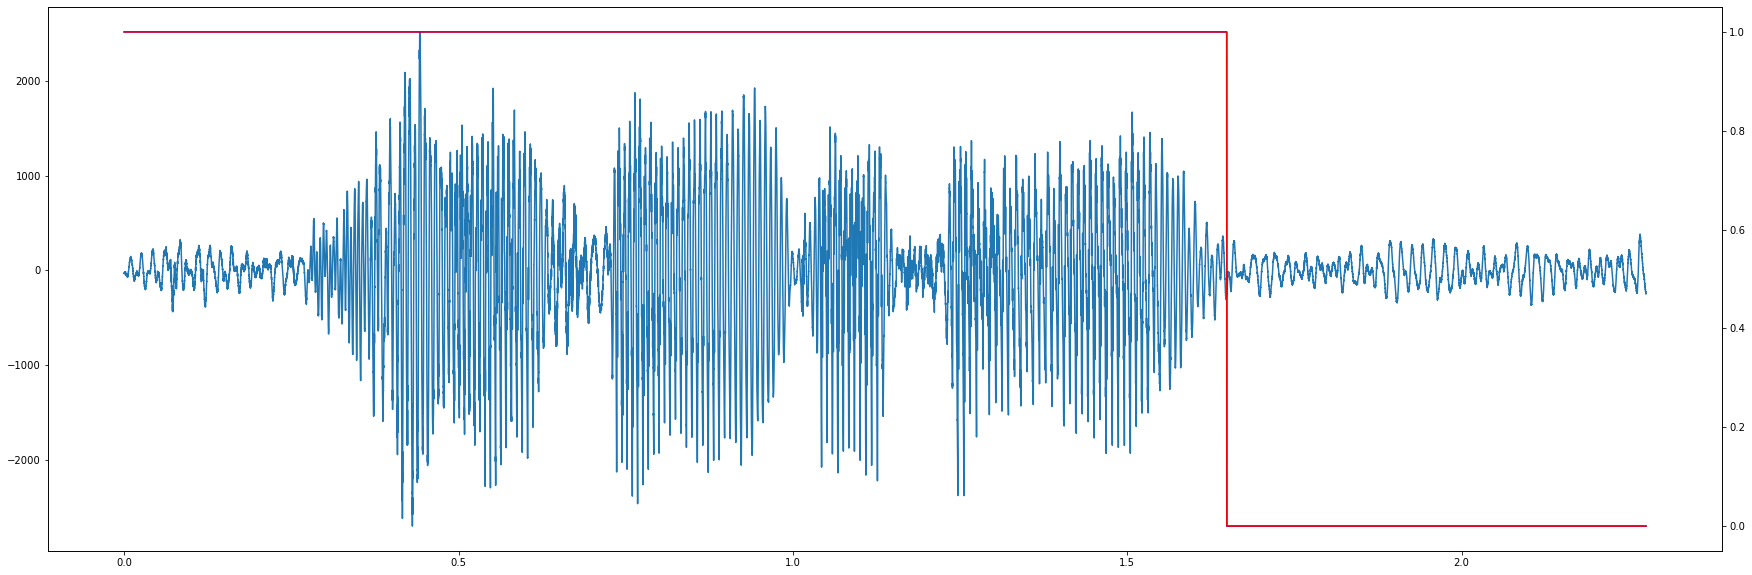

In [7]:
import time
# settings = {
#     "mode": "adaptive",
#     "startFrame": 5,
#     "stopFrame": 100,
#     "endingBoundary": 10,
#     "forgetFactor": 1,
#     "adjustment": 0.04,
#     "threshold": 15,
#     "smoothFrames": 5,
# }

settings = {
    "mode": "onset",
    "startFrame": 3,
    "stopFrame": 100,
    "smoothFrames": 5,
    "endingBoundary": 10,
    "alpha": 0.3,
    "trackingFactor": 0.02,
    "onsetThreshold": 10,
    "dynamicRange": 8,
}
rec = Recorder(
    channels=1,
    rate=44100,
    frames_per_buffer=1024,
    filename="recorded.wav",
    endPo_settings=settings
)
rec.start()
# sleep to make sure the main thread is kept open in non-blocking mode
time.sleep(10)
rec.terminate()